# Rice disease v.0.1

Simple datasetwith 120 images, 3 classes (no class for healthy) from
https://archive.ics.uci.edu/ml/datasets/Rice+Leaf+Diseases#

In [22]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models

import warnings
warnings.filterwarnings('ignore')

## Params

In [23]:
RANDOM_SEED = 9
TRAIN_SIZE = 0.8

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

BATCH_SIZE = 32

DEVICE = 'cpu'  # torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

DATALOADER_PIN_MEMORY = False  # Even on GPU it should be False :(
DATALOADER_NUM_WORKERS = 3

cpu


## Utils

In [24]:
def test_cuda():
    avail = torch.cuda.is_available()
    print(f'CUDA available: {avail}')
    
    if not avail:
        return
    
    print(f'Device: {torch.cuda.get_device_name(torch.cuda.current_device())}')
    print(f'Memory allocated:\t{torch.cuda.memory_allocated()}')
    print(f'Memory cached:\t\t{torch.cuda.memory_cached()}')

In [25]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [26]:
def show_images(loader, class_names, nrow=5, n_batches=1, figsize=(12,4)):
    # Grab the first batch of 10 images
    images = None
    labels = []
    
    for b, (img, lbl) in enumerate(loader): 
        if n_batches is not None and b >= n_batches:
            break
        
        images = img if images is None else torch.cat((images, img), dim=0)
        labels.extend(lbl.numpy())
        
    labels = np.array(labels).reshape(-1, nrow)
    
    # Print the labels
    print('Labels:\n', labels)
    print('\nClasses:', ' | '.join(np.array([class_names[i] for i in labels[0, :5]])), '...')

    im = make_grid(images, nrow=nrow)  # the default nrow is 8

    # Inverse normalize the images
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    im_inv = inv_normalize(im)

    # Print the images
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

In [27]:
def plot_results(train_losses, valid_losses, train_corrects, valid_corrects, train_len, valid_len):
    plt.figure(figsize=(14,5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='training loss')
    plt.plot(valid_losses, label='validation loss')
    plt.title('Loss at the end of each epoch')
    plt.legend();

    plt.subplot(1, 2, 2)
    plt.plot([100*t/train_len for t in train_corrects], label='training accuracy')
    plt.plot([100*t/valid_len for t in valid_corrects], label='validation accuracy')
    plt.title('Accuracy at the end of each epoch')
    plt.ylim((0, 100))
    plt.legend();

## Data

In [28]:
img_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(15),
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])]),
    'valid': transforms.Compose([transforms.Resize(224),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])])
}

In [29]:
data_folder = 'data/archive.ics.120small'
# data_folder = '/home/sergey-msu/Work/courses/udemy/pytorch-for-deep-learning-with-python-bootcamp/work/PYTORCH_NOTEBOOKS/Data/CATS_DOGS_SMALL/train'

In [30]:
all_data = datasets.ImageFolder(data_folder)
img_counts = Counter([img[1] for img in all_data.imgs])
cls_counts = {k:img_counts[i] for k,i in all_data.class_to_idx.items()}

In [31]:
print(all_data.class_to_idx)
print(cls_counts)
print('Total: ', len(all_data))

{'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2}
{'Bacterial leaf blight': 40, 'Brown spot': 40, 'Leaf smut': 40}
Total:  120


In [32]:
all_indices = list(range(len(all_data)))
np.random.shuffle(all_indices)

train_len = int(len(all_data)*TRAIN_SIZE)
valid_len = len(all_data) - train_len

train_indices = all_indices[:train_len]
valid_indices = all_indices[train_len:]

assert set(train_indices) | set(valid_indices) == set(all_indices)

In [33]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [34]:
train_loader = DataLoader(datasets.ImageFolder(data_folder, transform=img_transforms['train']), 
                          batch_size=BATCH_SIZE, 
                          sampler=train_sampler,
                          pin_memory=DATALOADER_PIN_MEMORY,
                          num_workers=DATALOADER_NUM_WORKERS)
valid_loader = DataLoader(datasets.ImageFolder(data_folder, transform=img_transforms['valid']), 
                          batch_size=BATCH_SIZE, 
                          sampler=valid_sampler,
                          pin_memory=DATALOADER_PIN_MEMORY,
                          num_workers=DATALOADER_NUM_WORKERS)

Labels:
 [[1 0 2 2 2 1 0 1]
 [2 1 1 1 2 2 0 0]
 [0 2 1 0 1 0 0 0]
 [2 0 2 0 2 0 0 0]
 [0 2 2 2 1 2 2 0]
 [1 1 0 1 2 0 1 1]
 [0 1 1 0 0 2 1 1]
 [2 1 2 2 1 1 1 0]
 [1 1 0 1 0 2 0 0]
 [1 0 2 1 2 1 1 2]
 [2 2 0 0 0 2 2 0]
 [0 0 1 2 1 0 2 0]]

Classes: Brown spot | Bacterial leaf blight | Leaf smut | Leaf smut | Leaf smut ...


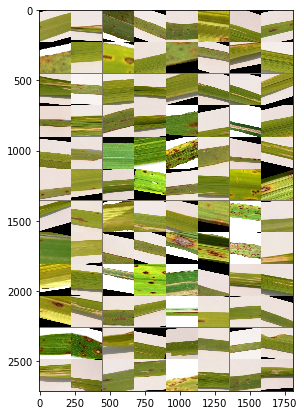

In [15]:
show_images(train_loader, all_data.classes, nrow=8, n_batches=None, figsize=(28, 7))

Labels:
 [[1 2 2 1 1 1]
 [0 1 2 1 0 2]
 [1 2 1 0 1 2]
 [0 2 2 2 0 2]]

Classes: Brown spot | Leaf smut | Leaf smut | Brown spot | Brown spot ...


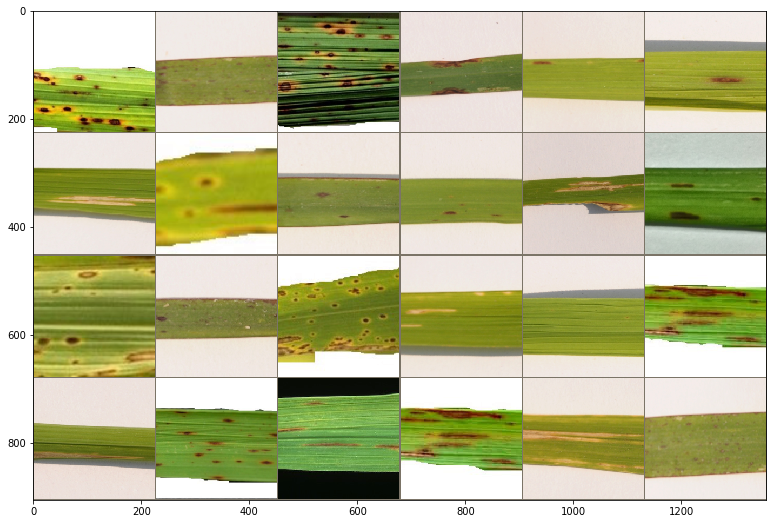

In [27]:
show_images(valid_loader, all_data.classes, nrow=6, n_batches=None, figsize=(14, 9))

## Model

In [35]:
test_cuda()

CUDA available: True
Device: GeForce GTX 960
Memory allocated:	24785920
Memory cached:		633339904


In [36]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 5, 2)
        self.fc1 = nn.Linear(27*27*32, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, 27*27*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)        

In [37]:
def train(model, criterion, optimizer, train_loader, valid_loader, n_epoch=30, device=DEVICE):
    start_time = time.time()

    train_losses = []
    valid_losses = []
    train_corrects = []
    valid_corrects = []
    
    print('Begin...')
    
    for i in range(n_epoch):
        
        # train
        
        train_correct = 0
        
        for b, (X_train, y_train) in enumerate(train_loader):
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            optimizer.zero_grad()
            
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            
            train_correct += (torch.max(y_pred, dim=1)[1] == y_train).sum()
            
        loss_val = round(float(loss), 2)
        correct_pct = round(train_correct.item()*100/train_len, 2)
        print(f'Epoch: {i+1}\tLoss: {loss_val}\tCorrect: {train_correct}/{train_len}({correct_pct}%)')
    
        train_losses.append(loss_val)
        train_corrects.append(train_correct)
        
        # validation
        
        valid_correct = 0
        
        with torch.no_grad():
            for b, (X_valid, y_valid) in enumerate(valid_loader):
                X_valid = X_valid.to(device)
                y_valid = y_valid.to(device)
                y_eval = model(X_valid)
                loss = criterion(y_eval, y_valid)
                valid_correct += (torch.max(y_eval, dim=1)[1] == y_valid).sum()
            
        loss_val = round(float(loss), 2)
        correct_pct = round(valid_correct.item()*100/valid_len, 2)
        print(f'  Test -->\tLoss: {loss_val}\tCorrect: {valid_correct}/{valid_len}({correct_pct}%)')
        print('----------------------------------------')
    
        valid_losses.append(loss_val)
        valid_corrects.append(valid_correct)

    end_time = time.time()
    print(f'End.\nDuration: {time.time() - start_time:.0f} seconds')
    
    return train_losses, valid_losses, train_corrects, valid_corrects

In [38]:
model = SimpleModel().to(DEVICE)
count_parameters(model)

     432
      16
   12800
      32
 2985984
     128
    8192
      64
     192
       3
________
 3007843


In [39]:
next(model.parameters()).is_cuda

False

In [40]:
train_losses, valid_losses, train_corrects, valid_corrects = \
    train(model,
          nn.CrossEntropyLoss(),
          torch.optim.Adam(model.parameters(), lr=0.0005),
          train_loader, valid_loader, 
          n_epoch=10)

Begin...
Epoch: 1	Loss: 1.1	Correct: 25/96(26.04%)
  Test -->	Loss: 1.06	Correct: 12/24(50.0%)
----------------------------------------
Epoch: 2	Loss: 1.09	Correct: 42/96(43.75%)
  Test -->	Loss: 1.08	Correct: 8/24(33.33%)
----------------------------------------
Epoch: 3	Loss: 0.95	Correct: 43/96(44.79%)
  Test -->	Loss: 1.15	Correct: 7/24(29.17%)
----------------------------------------
Epoch: 4	Loss: 1.15	Correct: 43/96(44.79%)
  Test -->	Loss: 1.1	Correct: 8/24(33.33%)
----------------------------------------
Epoch: 5	Loss: 0.92	Correct: 42/96(43.75%)
  Test -->	Loss: 0.97	Correct: 12/24(50.0%)
----------------------------------------
Epoch: 6	Loss: 0.86	Correct: 54/96(56.25%)
  Test -->	Loss: 0.97	Correct: 10/24(41.67%)
----------------------------------------
Epoch: 7	Loss: 1.1	Correct: 51/96(53.12%)
  Test -->	Loss: 0.95	Correct: 12/24(50.0%)
----------------------------------------
Epoch: 8	Loss: 1.02	Correct: 54/96(56.25%)
  Test -->	Loss: 1.01	Correct: 10/24(41.67%)
---------

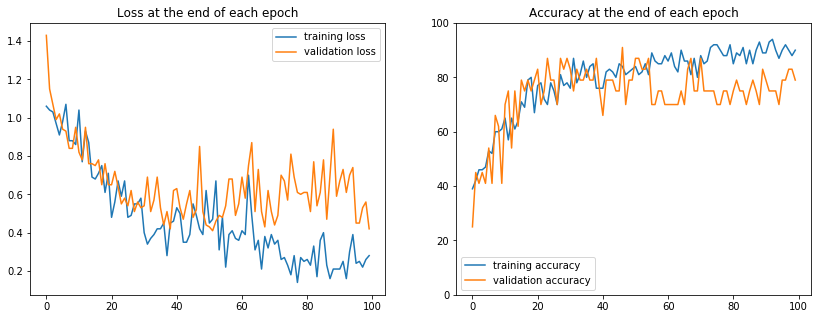

In [22]:
plot_results(train_losses, valid_losses, train_corrects, valid_corrects, train_len, valid_len)

In [30]:
test_cuda()

CUDA available: True
Device: GeForce GTX 960
Memory allocated:	24878080
Memory cached:		633339904


## Predict on a new images

Very low quality - images are really different.

In [75]:
test_data = datasets.ImageFolder('data/kaggle12Gb/LabelledRice/Labelled', transform=img_transforms['valid'])
test_img_counts = Counter([img[1] for img in test_data.imgs])
test_cls_counts = {k:test_img_counts[i] for k,i in test_data.class_to_idx.items()}

In [76]:
print(test_cls_counts)
print('Total: ', len(test_data))

{'BrownSpot': 523, 'Healthy': 1488, 'Hispa': 565, 'LeafBlast': 779}
Total:  3355


In [77]:
test_data.class_to_idx

{'BrownSpot': 0, 'Healthy': 1, 'Hispa': 2, 'LeafBlast': 3}

In [78]:
brown_spot_idx = test_data.class_to_idx['BrownSpot']

test_indices = list(range(len(test_data)))
brown_spot_indices = [i for i, (img, cls) in zip(test_indices, test_data.imgs) if cls == brown_spot_idx]

In [87]:
test_loader = DataLoader(test_data, 
                         batch_size=10,  #  len(brown_spot_indices), 
                         sampler=SubsetRandomSampler(brown_spot_indices),
                         pin_memory=DATALOADER_PIN_MEMORY,
                         num_workers=DATALOADER_NUM_WORKERS)

In [88]:
brown_spot_model_idx = all_data.class_to_idx['Brown spot']
test_len = len(test_indices)
y_test = torch.ones(test_len)*brown_spot_idx

for b, (X_test, y_test) in enumerate(test_loader):
    break
    
with torch.no_grad():
    y_eval = model(X_test)
    test_correct = (torch.max(y_eval, dim=1)[1] == y_test).sum()

correct_pct = round(test_correct.item()*100/test_len, 2)
print(f'Correct: {test_correct}/{test_len} ({correct_pct}%)')
print('----------------------------------------')

Correct: 2/3355 (0.06%)
----------------------------------------


In [89]:
Counter(torch.max(y_eval, dim=1)[1].numpy())

Counter({2: 7, 1: 1, 0: 2})

Labels:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]

Classes: BrownSpot | BrownSpot | BrownSpot | BrownSpot | BrownSpot ...


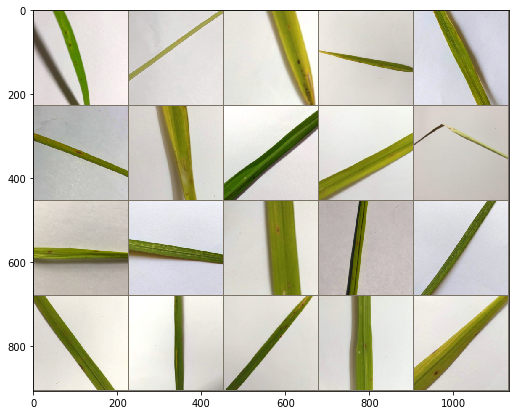

In [91]:
show_images(test_loader, test_data.classes, nrow=5, n_batches=2, figsize=(28, 7))

## Tests

In [3]:
import time
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(device)

cpu


In [4]:
start_time = time.time()

for i in range(10):
    print('iter', i)
    A = torch.randn(10000, 10000).to(device)
    B = torch.randn(10000, 10000).to(device)
    C = torch.mm(A, B)

end_time = time.time()
print(f'End.\nDuration: {time.time() - start_time:.0f} seconds')

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
End.
Duration: 59 seconds
